In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

pd.options.display.float_format = "{:,.3f}".format

## Load data

### Weather

Data Cleaning and adding new features:
- ``daytime`` - the total number of minutes from ``Sunrise`` to ``Sunset``
- ``rhumidity`` - the relative humidity based on ``dewpoint`` and ``tavg``

In [2]:
weather = pd.read_csv('https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/weather.csv')
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.700,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.700,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.000,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.300,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.700,7,11.9


In [3]:
# make all column names lowercase
weather.columns = weather.columns.str.lower()

**Drop redundant columns**

(explanation incomplete – feel free to add)
- Drop `codesum` since most of the values are either missing or rain(RA) / mist(BR)
- Drop `depth` because we are missing all our values and it is related to snowfall
- Drop `water1` since 100% of values are missing
- Drop `snowfall` since 50% of values are missing and almost 50% of values are 0. The WNV only occurs during summer months so `snowfall` is likely not a relevant variable as well.
- Drop `stnpressure` - no relevance to our project
- Drop `sealevel` - no relevance to our project
- Drop `heat` ,  `cool` 
Degree days are the difference between the daily temperature mean, (high temperature plus low temperature divided by two) and 65°F. If the temperature mean is above 65°F, we subtract 65 from the mean and the result is Cooling Degree Days. Degree days (in this context) are based on the assumption that when the outside temperature is 65°F, we don't need heating or cooling to be comfortable. THis is typically used for energy consumption (https://www.weather.gov/key/climate_heat_cool).
IN this instance Heat, Cool are not relevant in our findings, hence will drop both columns

In [4]:
# 'sealevel',

cols_to_drop = ['codesum', 'depth', 'water1', 'snowfall', 'stnpressure', 'heat', 'cool']
weather.drop(columns=cols_to_drop, inplace=True)

In [5]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,sunrise,sunset,preciptotal,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0448,1849,0.00,29.82,1.700,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,-,-,0.00,29.82,2.700,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,0447,1850,0.00,30.09,13.000,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,-,-,0.00,30.08,13.300,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,0446,1851,0.00,30.12,11.700,7,11.9


In [6]:
# there are missing values in `tavg` so we will use `tmin` and `tmax` to calculate average temp
weather['tavg'] = (weather.tmin + weather.tmax) / 2

# drop `tmin` and `tmax` since we don't need them anymore
# weather.drop(columns=['tmin', 'tmax'], inplace=True)

In [7]:
# Impute missing values for `sunrise` and `sunset` and engineer a `daytime` feature 

# Fill missing `sunrise` values in station 2 from station 1
for k, v in enumerate(weather['sunrise']):
    if v == '-' and weather.loc[k, 'station'] == 2:
        weather.loc[k, 'sunrise'] = weather.loc[k-1, 'sunrise']

# Fill missing `sunset` in station 2 from station 1
for k, v in enumerate(weather['sunset']):
    if v == '-' and weather.loc[k, 'station'] == 2:
        weather.loc[k, 'sunset'] = weather.loc[k-1, 'sunset']
        
# convert `sunrise` to datetime format
weather['sunrise'] = pd.to_datetime(weather['sunrise'].apply(lambda x: x[:2] + ':' + x[2:] + ':00')).dt.time

# there are 3 incorrect timestamp values in `sunset`
# replace all the wrong timestamp with the correct values
weather['sunset'] = np.where(weather['sunset'] == '1860', '1900', weather['sunset'])
weather['sunset'] = np.where(weather['sunset'] == '1760', '1800', weather['sunset'])
weather['sunset'] = np.where(weather['sunset'] == '1660', '1700', weather['sunset'])

# convert `sunset` to datetime format
weather['sunset'] = pd.to_datetime(weather['sunset'].apply(lambda x: x[:2] + ':' + x[2:] + ':00')).dt.time

# create a `daytime` column
weather['daytime'] = pd.to_timedelta(weather['sunset'].astype(str)) - pd.to_timedelta(weather['sunrise'].astype(str))

# convert `daytime` to minutes
weather['daytime'] = weather['daytime'].dt.total_seconds().div(60).astype(int)

# delete `sunrise` and `sunset` since we don't need them anymore
weather.drop(columns=['sunrise', 'sunset'], inplace=True)

In [8]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime
0,1,2007-05-01,83,50,66.500,14,51,56,0.00,29.82,1.700,27,9.2,841
1,2,2007-05-01,84,52,68.000,M,51,57,0.00,29.82,2.700,25,9.6,841
2,1,2007-05-02,59,42,50.500,-3,42,47,0.00,30.09,13.000,4,13.4,843
3,2,2007-05-02,60,43,51.500,M,42,47,0.00,30.08,13.300,2,13.4,843
4,1,2007-05-03,66,46,56.000,2,40,48,0.00,30.12,11.700,7,11.9,845


#### Impute missing values in weather dataset

In [9]:
# helper function to impute missing values in station 1 with station 2's values and vice versa

def impute_values(col):
    for k,v in enumerate(weather[col]):
        if v == 'M' and weather.loc[k, 'station'] == 1:
            weather.loc[k, col] = weather.loc[k+1, col]
        if v == 'M' and weather.loc[k, 'station'] == 2:
            weather.loc[k, col] = weather.loc[k-1, col]

In [10]:
# find any remaining rows that contain 'M'
weather[weather.apply(lambda row: row.astype(str).str.contains('M').any(), axis=1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime
1,2,2007-05-01,84,52,68.000,M,51,57,0.00,29.82,2.700,25,9.6,841
3,2,2007-05-02,60,43,51.500,M,42,47,0.00,30.08,13.300,2,13.4,843
5,2,2007-05-03,67,48,57.500,M,40,50,0.00,30.12,12.900,6,13.2,845
7,2,2007-05-04,78,51,64.500,M,42,50,0.00,30.04,10.100,7,10.4,848
9,2,2007-05-05,66,54,60.000,M,39,50,T,30.09,11.200,7,11.5,850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2,2014-10-27,79,54,66.500,M,52,59,0.02,29.67,12.700,19,13.6,635
2937,2,2014-10-28,66,48,57.000,M,40,48,0.03,29.85,14.000,26,14.6,632
2939,2,2014-10-29,49,40,44.500,M,34,42,0.00,30.07,8.500,29,9.0,630
2941,2,2014-10-30,53,37,45.000,M,35,42,T,30.10,5.900,23,6.5,627


In [11]:
# impute missing values for `preciptotal`
# check 'M' values
weather[weather['preciptotal'] == 'M']

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime
117,2,2007-06-28,73,61,67.000,M,56,61,M,30.07,12.200,2,13.3,912
119,2,2007-06-29,71,56,63.500,M,56,60,M,30.11,7.400,2,8.2,912


In [12]:
# the 2 missing values are from station 2
# so we will impute 'M' with values from station 1
impute_values('preciptotal')

In [13]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime
0,1,2007-05-01,83,50,66.500,14,51,56,0.00,29.82,1.700,27,9.2,841
1,2,2007-05-01,84,52,68.000,M,51,57,0.00,29.82,2.700,25,9.6,841
2,1,2007-05-02,59,42,50.500,-3,42,47,0.00,30.09,13.000,4,13.4,843
3,2,2007-05-02,60,43,51.500,M,42,47,0.00,30.08,13.300,2,13.4,843
4,1,2007-05-03,66,46,56.000,2,40,48,0.00,30.12,11.700,7,11.9,845


In [14]:
# replace trace amounts of precipitation(https://www.thoughtco.com/what-is-trace-of-precipitation-3444238) with 0.001
weather['preciptotal'] = np.where(weather['preciptotal'] == '  T', '0.001', weather['preciptotal'])

In [15]:
# use values from the other station to impute missing values for `avgspeed`
impute_values('avgspeed')

In [16]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime
0,1,2007-05-01,83,50,66.500,14,51,56,0.00,29.82,1.700,27,9.2,841
1,2,2007-05-01,84,52,68.000,M,51,57,0.00,29.82,2.700,25,9.6,841
2,1,2007-05-02,59,42,50.500,-3,42,47,0.00,30.09,13.000,4,13.4,843
3,2,2007-05-02,60,43,51.500,M,42,47,0.00,30.08,13.300,2,13.4,843
4,1,2007-05-03,66,46,56.000,2,40,48,0.00,30.12,11.700,7,11.9,845


In [17]:
# use values from the other station to impute missing values for `depart`
impute_values('depart')

In [18]:
# find any remaining rows that contain 'M'
weather[weather.apply(lambda row: row.astype(str).str.contains('M').any(), axis=1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime
87,2,2007-06-13,86,68,77.000,6,53,62,0.00,M,7.000,5,8.6,911
832,1,2009-06-18,80,61,70.500,1,63,67,0.12,M,6.700,16,7.9,913
848,1,2009-06-26,86,69,77.500,7,60,M,0.00,29.85,6.400,4,8.2,913
994,1,2009-09-07,77,59,68.000,1,59,62,0.00,M,5.800,3,4.0,774
1732,1,2011-09-08,75,57,66.000,0,53,59,0.001,M,13.000,2,13.4,771
1745,2,2011-09-14,60,48,54.000,-11,45,51,0.001,M,6.000,32,7.3,755
1756,1,2011-09-20,74,49,61.500,0,54,58,0.00,M,7.300,18,7.3,736
2067,2,2012-08-22,84,72,78.000,-1,51,61,0.00,M,4.700,19,5.8,817
2090,1,2012-09-03,88,71,79.500,12,70,73,0.00,M,4.600,6,4.4,785
2410,1,2013-08-10,81,64,72.500,0,57,M,0.00,30.08,5.300,5,6.5,846


In [19]:
# use values from the other station to impute missing values for `wetbulb`
impute_values('wetbulb')

In [20]:
weather['date'] = pd.to_datetime(weather['date'])

In [21]:
#To Create a new column 'rhumidity' for relative humidity
#A function to calculate relative humidity
def cal_rH(temp):
    """
    Function converts temp(in deg F to Deg C) to calculate the relatve humidity using formula
    -  100*(np.exp((17.625*dewpoint)/(243.04+dewpoint))/np.exp((17.625*Temp)/(243.04+Temp)))
    
    Reference:
    https://bmcnoldy.rsmas.miami.edu/Humidity.html
    
    Take in arguements:
    - temp - list of dewpoint and avg temp in F
    
    returns:
    - Relative Humidity rH
    """

    #convert dewpoint to Deg C
    TD = (temp[0] - 32) * 5/9
    #convert Tavg to Deg C
    T = (temp[1] - 32) * 5/9

    rH =100*(np.exp((17.625*TD)/(243.04+TD))/np.exp((17.625*T)/(243.04+T)))
    
    return rH

In [22]:
weather['rH_temp'] = list(zip(weather['dewpoint'], weather['tavg']))

# apply the function and create the `rhumidity` column
weather['rhumidity'] = weather['rH_temp'].apply(cal_rH)

#drop after gotten the relative humidity value
weather.drop(columns='rH_temp', inplace=True)

In [23]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity
0,1,2007-05-01,83,50,66.500,14,51,56,0.00,29.82,1.700,27,9.2,841,57.423
1,2,2007-05-01,84,52,68.000,14,51,57,0.00,29.82,2.700,25,9.6,841,54.526
2,1,2007-05-02,59,42,50.500,-3,42,47,0.00,30.09,13.000,4,13.4,843,72.527
3,2,2007-05-02,60,43,51.500,-3,42,47,0.00,30.08,13.300,2,13.4,843,69.892
4,1,2007-05-03,66,46,56.000,2,40,48,0.00,30.12,11.700,7,11.9,845,54.875


In [24]:
# check datatypes
weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                 object
dewpoint                int64
wetbulb                object
preciptotal            object
sealevel               object
resultspeed           float64
resultdir               int64
avgspeed               object
daytime                 int64
rhumidity             float64
dtype: object

In [25]:
impute_values('sealevel')

In [26]:
# convert numerical columns to numerical datatype
weather['depart'] = pd.to_numeric(weather['depart'])
weather['wetbulb'] = pd.to_numeric(weather['wetbulb'])
weather['preciptotal'] = pd.to_numeric(weather['preciptotal'])
weather['avgspeed'] = pd.to_numeric(weather['avgspeed'])

weather['sealevel'] = pd.to_numeric(weather['sealevel'])


### Train

In [27]:
train = pd.read_csv('https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/train.csv')

In [28]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.955,-87.801,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.955,-87.801,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.995,-87.769,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974,-87.825,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974,-87.825,8,4,0


In [29]:
# make all column names lowercase
train.columns = train.columns.str.lower()

In [30]:
# convert `date` to datetime datatype
train['date'] = pd.to_datetime(train['date'])

# create new datetime element columns
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['weekofyear'] = train.date.dt.weekofyear 
train['yearmonth'] = train['year'].apply(str) + '-' + train['month'].apply(str) # ZX: not sure if relevant 
train['weekday'] = train.date.dt.day_name() # ZX: not sure if relevant

/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [31]:
# drop the redundant location columns since we have `latitude` and `longitude`
train.drop(columns=['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace=True)

In [32]:
train.dtypes

date            datetime64[ns]
species                 object
trap                    object
latitude               float64
longitude              float64
nummosquitos             int64
wnvpresent               int64
year                     int64
month                    int64
weekofyear               int64
yearmonth               object
weekday                 object
dtype: object

In [33]:
train.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,1,0,2007,5,22,2007-5,Tuesday
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,1,0,2007,5,22,2007-5,Tuesday
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,4,0,2007,5,22,2007-5,Tuesday


**For each trap, identify the closer weather station and create a column to store the results**

- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level

- Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [34]:


# create function to find the closer weather station from each trap
import geopy.distance
def closest_dist(coords):
    coords_s1 = (41.995, -87.933) # coordinates of station 1
    coords_s2 = (41.786, -87.752) # coordinates of station 2
    dist_from_s1 = geopy.distance.distance(coords_s1, coords).km
    dist_from_s2 = geopy.distance.distance(coords_s2, coords).km
    if dist_from_s1 > dist_from_s2:
        return 2
    else:
        return 1

train['coords'] = list(zip(train['latitude'], train['longitude']))

# apply the function and create the `closest_station` column
train['closest_station'] = train['coords'].apply(closest_dist)

In [35]:
# delete the `coords` column
train.drop(columns='coords', inplace=True)

<AxesSubplot:>

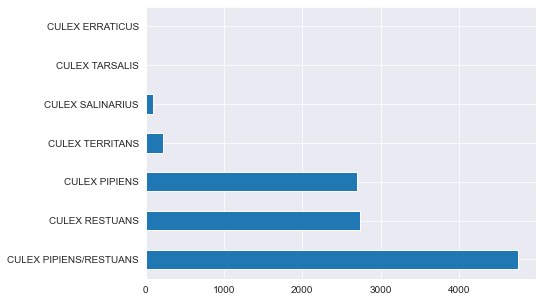

In [36]:
# distribution of mosquito species
train.species.value_counts().plot(kind='barh', figsize=(7,5))

In [37]:
# group all the mosquito species that do not carry WNV as `OTHER`

# list of species to replace with `OTHER`
other = ['CULEX ERRATICUS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS']
# replace selected species with `OTHER`
train['species'] = train['species'].apply(lambda x: 'OTHER' if x in other else x)

In [38]:
train.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday,closest_station
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,1,0,2007,5,22,2007-5,Tuesday,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,1,0,2007,5,22,2007-5,Tuesday,1
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,4,0,2007,5,22,2007-5,Tuesday,1


In [39]:
# Left join `weather` to `train` using `date` and `station` as keys
train = pd.merge(train, weather, left_on=['date', 'closest_station'], right_on=['date', 'station'], how="left")

**NEW**

- calculate rolling average temperature (7D, 14D, 30D)

- Find TRAPS with the highest number of mosquitoes with WNV

In [40]:
pd.set_option('display.max_columns', None)

In [41]:
train.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,4,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398


Text(0, 0.5, 'No. of mosquitos')

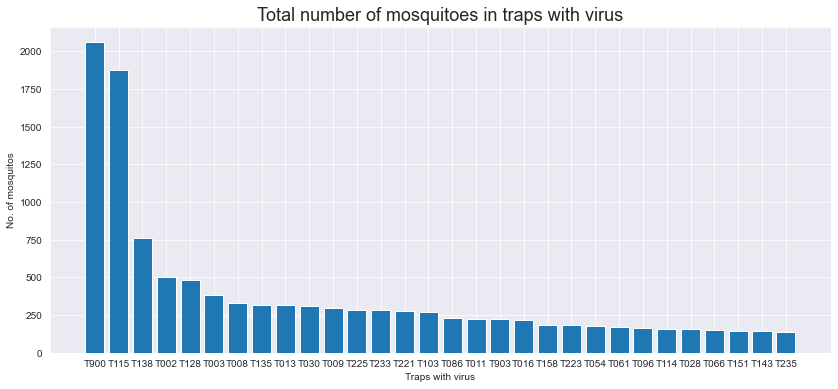

In [42]:
# number of mosquitos by trap (wnv=1)
wnv_mosquitos_trap = train[train['wnvpresent'] == 1].groupby(['trap'])['nummosquitos']\
                    .agg(['count','sum'])\
                    .reset_index()\
                    .sort_values('sum', ascending=False).head(30)
wnv_mosquitos_trap.rename(columns={'count': 'samplecount', 'sum': 'mosquitocount'}, inplace=True)

plt.figure(figsize=(14,6))
plt.bar(wnv_mosquitos_trap["trap"], wnv_mosquitos_trap["mosquitocount"])
plt.title("Total number of mosquitoes in traps with virus", fontsize=18)
plt.xlabel("Traps with virus")
plt.ylabel("No. of mosquitos")

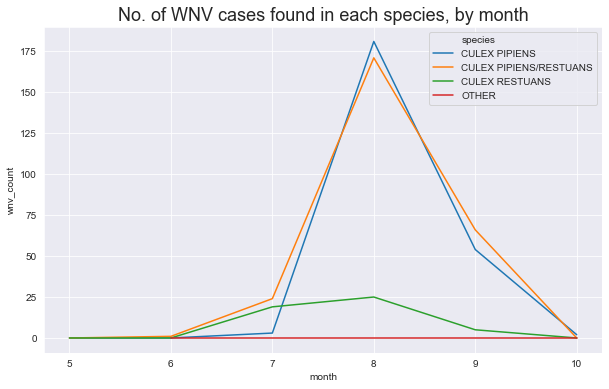

In [43]:
monthly_wnv_count = train.groupby(['month', 'species']).agg(wnv_count=('wnvpresent', 'sum')).reset_index()

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data = monthly_wnv_count, x='month', y= 'wnv_count', hue='species')
ax.set_title('No. of WNV cases found in each species, by month', fontsize=18);

In [44]:
# plot graphs for average temperature by year

# create temporary DF to calculate the average `tvg` across stations 1 and 2 for each day
temp = weather[['date', 'tavg']].groupby('date').mean()

In [45]:
train.dtypes

date               datetime64[ns]
species                    object
trap                       object
latitude                  float64
longitude                 float64
nummosquitos                int64
wnvpresent                  int64
year                        int64
month                       int64
weekofyear                  int64
yearmonth                  object
weekday                    object
closest_station             int64
station                     int64
tmax                        int64
tmin                        int64
tavg                      float64
depart                      int64
dewpoint                    int64
wetbulb                     int64
preciptotal               float64
sealevel                  float64
resultspeed               float64
resultdir                   int64
avgspeed                  float64
daytime                     int64
rhumidity                 float64
dtype: object

In [46]:
train.corr()['wnvpresent'].sort_values()

daytime           -0.080
longitude         -0.060
closest_station   -0.060
station           -0.060
resultspeed       -0.045
avgspeed          -0.032
resultdir         -0.001
sealevel           0.009
preciptotal        0.021
latitude           0.029
tmax               0.048
year               0.051
depart             0.055
rhumidity          0.058
tavg               0.059
tmin               0.065
wetbulb            0.079
dewpoint           0.085
month              0.100
weekofyear         0.104
nummosquitos       0.197
wnvpresent         1.000
Name: wnvpresent, dtype: float64

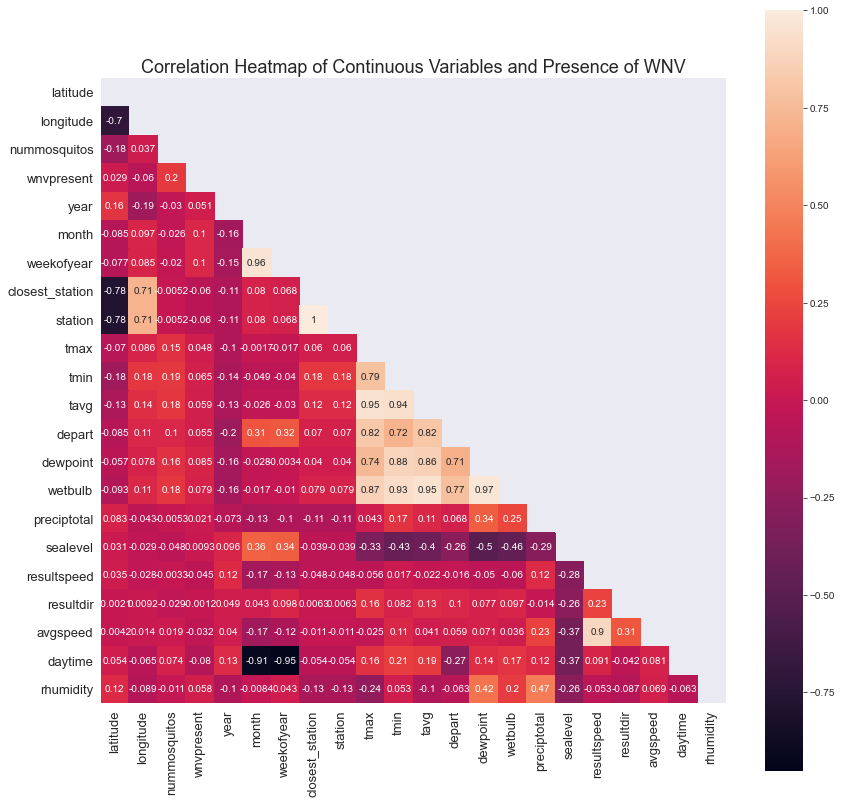

In [47]:
# instantiate a figure
plt.figure(figsize=(14,14))

ax = plt.axes()
ax.set_title('Correlation Heatmap of Continuous Variables and Presence of WNV', fontsize=18)

# set up mask to be "True" in the upper triangle
mask = np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True
plt.tick_params(axis = 'both', which = 'major', labelsize = 13)

# plotting heatmap while masking upper triangle with white
with sns.axes_style("white"):
    sns.heatmap(train.corr(), mask=mask, square = True, annot=True)

In [48]:
train.describe()

,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity
count,"10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000","10,506.000"
mean,41.841,-87.700,12.854,0.052,"2,009.576",7.693,31.687,1.686,1.686,81.929,63.991,72.960,2.740,59.654,64.873,0.137,29.958,5.918,17.688,7.456,840.410,63.688
std,0.113,0.097,16.134,0.223,2.355,1.068,4.527,0.464,0.464,8.286,7.585,7.498,6.486,7.839,6.709,0.341,0.117,2.903,9.136,2.522,62.886,9.298
min,41.645,-87.931,1.000,0.000,"2,007.000",5.000,22.000,1.000,1.000,57.000,41.000,50.000,-12.000,38.000,46.000,0.000,29.590,0.100,1.000,2.100,683.000,42.229
25%,41.733,-87.760,2.000,0.000,"2,007.000",7.000,28.000,1.000,1.000,78.000,60.000,69.500,-2.000,54.000,61.000,0.000,29.880,3.900,9.000,5.800,798.000,56.195
50%,41.846,-87.695,5.000,0.000,"2,009.000",8.000,31.000,2.000,2.000,83.000,66.000,74.500,4.000,60.000,66.000,0.000,29.960,5.500,19.000,7.100,858.000,62.195
75%,41.955,-87.628,17.000,0.000,"2,011.000",8.000,35.000,2.000,2.000,88.000,70.000,78.500,8.000,66.000,70.000,0.090,30.050,7.800,24.000,9.200,897.000,71.620
max,42.017,-87.532,50.000,1.000,"2,013.000",10.000,41.000,2.000,2.000,97.000,79.000,86.500,18.000,73.000,76.000,3.970,30.330,15.400,36.000,16.300,914.000,88.418


In [49]:
train[train['wnvpresent']==1][['tavg', 'depart', 'dewpoint', 'wetbulb', 'preciptotal', 'avgspeed', 'resultspeed', 'resultdir', 'daytime', 'rhumidity']].describe()

,tavg,depart,dewpoint,wetbulb,preciptotal,avgspeed,resultspeed,resultdir,daytime,rhumidity
count,551.000,551.000,551.000,551.000,551.000,551.000,551.000,551.000,551.000,551.000
mean,74.848,4.269,62.483,67.123,0.168,7.114,5.369,17.641,819.123,65.991
std,5.355,5.208,6.799,5.364,0.312,2.218,2.633,8.894,39.992,9.311
min,52.000,-12.000,38.000,47.000,0.000,2.100,0.100,1.000,697.000,50.647
25%,72.000,0.000,58.000,64.000,0.000,5.800,3.500,10.000,798.000,58.102
50%,75.000,5.000,64.000,69.000,0.000,7.000,4.700,20.000,820.000,63.909
75%,78.000,8.000,67.500,71.000,0.230,8.400,6.650,24.000,851.000,75.394
max,86.500,18.000,73.000,76.000,1.310,14.000,13.400,36.000,912.000,81.494


In [50]:
train[train['wnvpresent']==0][['tavg', 'depart', 'dewpoint', 'wetbulb', 'preciptotal', 'avgspeed', 'resultspeed', 'resultdir', 'daytime', 'rhumidity']].describe()

,tavg,depart,dewpoint,wetbulb,preciptotal,avgspeed,resultspeed,resultdir,daytime,rhumidity
count,"9,955.000","9,955.000","9,955.000","9,955.000","9,955.000","9,955.000","9,955.000","9,955.000","9,955.000","9,955.000"
mean,72.855,2.656,59.497,64.749,0.135,7.475,5.949,17.691,841.588,63.560
std,7.586,6.540,7.863,6.754,0.343,2.536,2.914,9.150,63.708,9.281
min,50.000,-12.000,38.000,46.000,0.000,2.100,0.100,1.000,683.000,42.229
25%,69.500,-2.000,54.000,61.000,0.000,5.800,3.900,9.000,801.000,56.195
50%,74.500,4.000,60.000,65.000,0.000,7.200,5.800,19.000,864.000,62.195
75%,78.500,8.000,66.000,70.000,0.090,9.200,7.800,24.000,899.000,71.603
max,86.500,18.000,73.000,76.000,3.970,16.300,15.400,36.000,914.000,88.418


**General observations**

...

- Drop `resultdir` because there is negligible difference in its statistical values for wnv=1 and wnv=0. `resultdir` also has the lowest correlation with `wnvpresent`.


- `wetbulb` and `dewpoint` are highly correlated. We will drop `wetbulb` since it has a lower correlation with `wnvpresent`.


- `avgspeed` and `resultspeed` are highly correlated. Drop `avgspeed` since it has a lower correlation with `wnvpresent`.

In [51]:
# drop `resultdir`, `wetbulb` and `avgspeed` 

# train.drop(columns=['resultdir', 'avgspeed'], inplace=True)

In [52]:
train.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,4,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398


#### Set up a `row_count` column

In [56]:
row_count = train[['date', 'species', 'trap', 'nummosquitos']]\
                .groupby(['date', 'species', 'trap'])\
                    .agg(row_count=('species', 'count')).reset_index().sort_values('row_count')

train = train.merge(row_count, how='left', on=['date', 'species', 'trap'])

<AxesSubplot:xlabel='weekday', ylabel='nummosquitos'>

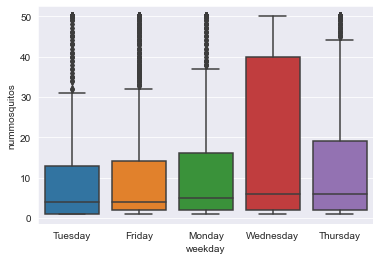

In [58]:
sns.boxplot(data=train, x='weekday', y='nummosquitos')

#### Rolling averages

In [59]:
for col in ['tavg', 'resultspeed', 'dewpoint', 'rhumidity', 'tmax', 'tmin']:
    for period in [14,30,60,90]:
        train[f'{col}_{str(period)}'] = train[col].rolling(period, min_periods=1).mean()

In [60]:
train.corr()['wnvpresent']

latitude           0.029
longitude         -0.060
nummosquitos       0.197
wnvpresent         1.000
year               0.051
month              0.100
weekofyear         0.104
closest_station   -0.060
station           -0.060
tmax               0.048
tmin               0.065
tavg               0.059
depart             0.055
dewpoint           0.085
wetbulb            0.079
preciptotal        0.021
sealevel           0.009
resultspeed       -0.045
resultdir         -0.001
avgspeed          -0.032
daytime           -0.080
rhumidity          0.058
row_count          0.060
tavg_14            0.060
tavg_30            0.061
tavg_60            0.062
tavg_90            0.064
resultspeed_14    -0.046
resultspeed_30    -0.050
resultspeed_60    -0.057
resultspeed_90    -0.065
dewpoint_14        0.083
dewpoint_30        0.083
dewpoint_60        0.083
dewpoint_90        0.087
rhumidity_14       0.055
rhumidity_30       0.055
rhumidity_60       0.054
rhumidity_90       0.058
tmax_14            0.046


In [61]:
# drop the 30-day and 60-day rolling averages since the 90-day rolling average has the highest correlation with `wnvpresent`
# train.drop(columns=['tavg_30', 'tavg_60', 'resultspeed_30', 'resultspeed_60'], inplace=True)

In [62]:
train

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity,row_count,tavg_14,tavg_30,tavg_60,tavg_90,resultspeed_14,resultspeed_30,resultspeed_60,resultspeed_90,dewpoint_14,dewpoint_30,dewpoint_60,dewpoint_90,rhumidity_14,rhumidity_30,rhumidity_60,rhumidity_90,tmax_14,tmax_30,tmax_60,tmax_90,tmin_14,tmin_30,tmin_60,tmin_90
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,4,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,T035,41.764,-87.742,6,1,2013,9,39,2013-9,Thursday,2,2,75,55,65.000,3,52,58,0.000,30.040,4.100,9,4.600,719,62.768,1,64.107,64.083,64.458,64.622,3.993,3.990,4.035,4.111,52.000,52.000,52.000,52.333,64.819,64.874,64.013,64.440,75.000,75.000,75.000,75.200,53.214,53.167,53.917,54.044
10502,2013-09-26,CULEX PIPIENS/RESTUANS,T231,41.987,-87.666,5,0,2013,9,39,2013-9,Thursday,1,1,75,50,62.500,3,52,58,0.000,30.040,3.800,8,4.200,719,68.512,1,64.107,64.000,64.417,64.467,3.993,3.980,4.030,4.061,52.000,52.000,52.000,52.156,64.819,65.066,64.108,64.368,75.000,75.000,75.000,75.100,53.214,53.000,53.833,53.833
10503,2013-09-26,CULEX PIPIENS/RESTUANS,T232,41.913,-87.668,1,0,2013,9,39,2013-9,Thursday,2,2,75,55,65.000,3,52,58,0.000,30.040,4.100,9,4.600,719,62.768,1,64.286,64.000,64.417,64.333,4.014,3.980,4.030,4.020,52.000,52.000,52.000,52.000,64.409,65.066,64.108,64.300,75.000,75.000,75.000,75.000,53.571,53.000,53.833,53.667
10504,2013-09-26,CULEX PIPIENS/RESTUANS,T233,42.010,-87.807,5,0,2013,9,39,2013-9,Thursday,1,1,75,50,62.500,3,52,58,0.000,30.040,3.800,8,4.200,719,68.512,1,64.107,63.917,64.417,64.333,3.993,3.970,4.030,4.020,52.000,52.000,52.000,52.000,64.819,65.257,64.108,64.300,75.000,75.000,75.000,75.000,53.214,52.833,53.833,53.667


**END OF NEW**

In [63]:
# create dummy variables for `species` and `trap`
train_dum = pd.get_dummies(data=train, columns=['species'])

In [64]:
train_dum.shape

(10506, 55)

### Test

In [147]:
test = pd.read_csv('https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/test.csv')

In [165]:
train_dum.head()

,date,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity,row_count,tavg_14,tavg_30,tavg_60,tavg_90,resultspeed_14,resultspeed_30,resultspeed_60,resultspeed_90,dewpoint_14,dewpoint_30,dewpoint_60,dewpoint_90,rhumidity_14,rhumidity_30,rhumidity_60,rhumidity_90,tmax_14,tmax_30,tmax_60,tmax_90,tmin_14,tmin_30,tmin_60,tmin_90,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER
0,2007-05-29,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,1,0,0
1,2007-05-29,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,0,1,0
2,2007-05-29,T007,41.995,-87.769,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,0,1,0
3,2007-05-29,T015,41.974,-87.825,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,1,0,0
4,2007-05-29,T015,41.974,-87.825,4,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,0,1,0


In [148]:
# make all column names lowercase
test.columns = test.columns.str.lower()

In [149]:
# convert `date` to datetime datatype
test['date'] = pd.to_datetime(test['date'])

# create new datetime element columns
test['year'] = test.date.dt.year
test['month'] = test.date.dt.month
test['weekofyear'] = test.date.dt.weekofyear 
test['yearmonth'] = test['year'].apply(str) + '-' + train['month'].apply(str) # ZX: not sure if relevant 
test['weekday'] = test.date.dt.day_name() # ZX: not sure if relevant

/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [150]:
# drop the redundant location columns since we have `latitude` and `longitude`
test.drop(columns=['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace=True)

In [151]:
set(test.species.values)

{'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS',
 'UNSPECIFIED CULEX'}

In [152]:
# group all the mosquito species that do not carry WNV as `OTHER`
# in the `test` set, there is an additional `UNSPECIFIED CULEX` species

# list of species to replace with `OTHER`
other = ['CULEX ERRATICUS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS', 'UNSPECIFIED CULEX']
# replace selected species with `OTHER`
test['species'] = test['species'].apply(lambda x: 'OTHER' if x in other else x)

In [153]:
train['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'OTHER'], dtype=object)

In [154]:
test['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'OTHER'], dtype=object)

In [155]:
test['coords'] = list(zip(test['latitude'], test['longitude']))

# apply the function and create the `closest_station` column
test['closest_station'] = test['coords'].apply(closest_dist)

In [156]:
del test['coords']

In [157]:
test.head()

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth,weekday,closest_station
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1
1,2,2008-06-11,CULEX RESTUANS,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1
2,3,2008-06-11,CULEX PIPIENS,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1
3,4,2008-06-11,OTHER,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1
4,5,2008-06-11,OTHER,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1


In [158]:
# Left join `weather` to `test` using `date` and `station` as keys
test = pd.merge(test, weather, left_on=['date', 'closest_station'], right_on=['date', 'station'], how="left")

#### Set up a `row_count` column

In [159]:
row_count = test[['date', 'species', 'trap']]\
                .groupby(['date', 'species', 'trap'])\
                    .agg(row_count=('species', 'count')).reset_index().sort_values('row_count')

test = test.merge(row_count, how='left', on=['date', 'species', 'trap'])

#### Rolling averages

In [162]:
for col in ['tavg', 'resultspeed', 'dewpoint', 'rhumidity', 'tmax', 'tmin']:
    for period in [14,30,60,90]:
        test[f'{col}_{str(period)}'] = test[col].rolling(period, min_periods=1).mean()

In [166]:
test.head()

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity,row_count,tavg_14,tavg_30,tavg_60,tavg_90,resultspeed_14,resultspeed_30,resultspeed_60,resultspeed_90,dewpoint_14,dewpoint_30,dewpoint_60,dewpoint_90,rhumidity_14,rhumidity_30,rhumidity_60,rhumidity_90,tmax_14,tmax_30,tmax_60,tmax_90,tmin_14,tmin_30,tmin_60,tmin_90
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000
1,2,2008-06-11,CULEX RESTUANS,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000
2,3,2008-06-11,CULEX PIPIENS,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000
3,4,2008-06-11,OTHER,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,5,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000
4,5,2008-06-11,OTHER,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,5,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000


In [167]:
# create dummy variables for `species` and `trap`
test_dum = pd.get_dummies(data=test, columns=['species'])

In [168]:
test_dum.head()

,id,date,trap,latitude,longitude,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity,row_count,tavg_14,tavg_30,tavg_60,tavg_90,resultspeed_14,resultspeed_30,resultspeed_60,resultspeed_90,dewpoint_14,dewpoint_30,dewpoint_60,dewpoint_90,rhumidity_14,rhumidity_30,rhumidity_60,rhumidity_90,tmax_14,tmax_30,tmax_60,tmax_90,tmin_14,tmin_30,tmin_60,tmin_90,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER
0,1,2008-06-11,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,0,1,0,0
1,2,2008-06-11,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,0,0,1,0
2,3,2008-06-11,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,1,0,0,0
3,4,2008-06-11,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,5,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,0,0,0,1
4,5,2008-06-11,T002,41.955,-87.801,2008,6,24,2008-5,Wednesday,1,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,5,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,0,0,0,1


### Spray 

In [82]:
spray = pd.read_csv('https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/spray.csv')

In [83]:
# make all column names lowercase
spray.columns = spray.columns.str.lower()

In [84]:
spray.head()

,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.392,-88.089
1,2011-08-29,6:57:08 PM,42.391,-88.089
2,2011-08-29,6:57:18 PM,42.391,-88.089
3,2011-08-29,6:57:28 PM,42.391,-88.089
4,2011-08-29,6:57:38 PM,42.390,-88.089


### Map plot of sprays, traps, and WNV cases

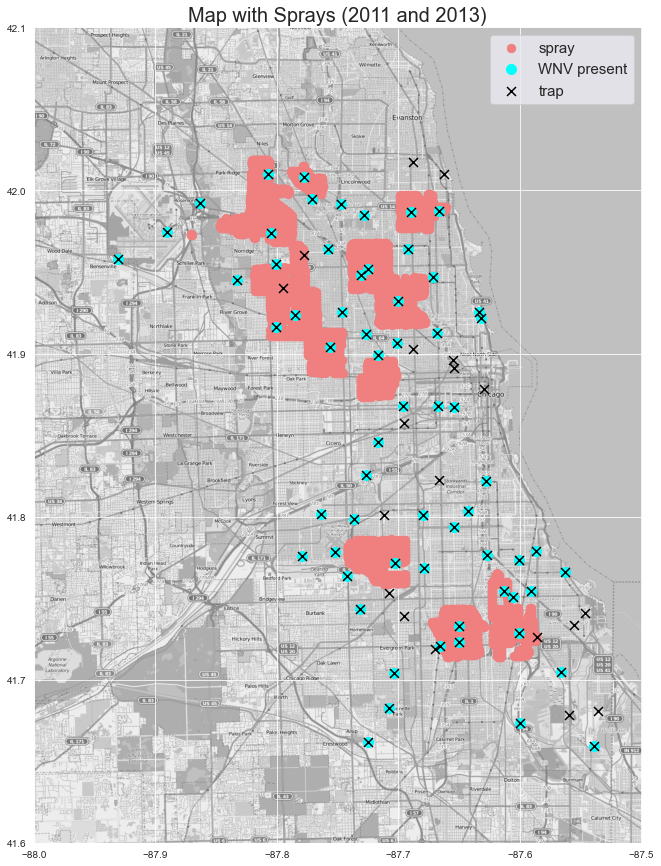

In [85]:
# load map in txt format
mapdata = np.loadtxt("https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/mapdata_copyright_openstreetmap_contributors.txt")

# setting the map boundaries
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
long_lat_box = (-88, -87.5, 41.6, 42.1)

# drop duplicate `longitude` and `latitude` for spray locations as we only need unique coordinates for plotting
spray_plots = spray[['longitude', 'latitude']].drop_duplicates()

# remove trap locations that are outside the boundaries of the map region
spray_plots = spray_plots[spray_plots['longitude'] > -88].values

# locations of ALL traps, whether or not WNV was detected there
# extract only the 2011 and 2013 trap locations since we only have spray data for those 2 years
# drop duplicate `longitude` and `latitude` for trap locations as we only need unique coordinates for plotting
trap_plots = train[train['year'].isin([2011, 2013])][['longitude', 'latitude']].drop_duplicates().values

# locations of ONLY traps with WNV detected
# extract only the 2011 and 2013 trap locations since we only have spray data for those 2 years
# drop duplicate `longitude` and `latitude` for trap locations as we only need unique coordinates for plotting
wnv_trap_plots = train[(train['year'].isin([2011, 2013])) & (train['wnvpresent']==1)][['longitude', 'latitude']].drop_duplicates().values

# create figure of the map 
plt.figure(figsize=(15,15))
plt.title('Map with Sprays (2011 and 2013)', fontsize=20)
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=long_lat_box,
          aspect=aspect);

# plot out the spray, trap, and WNV locations
plt.scatter(spray_plots[:,0], spray_plots[:,1], c='lightcoral', s=70, alpha=1, label='spray')
plt.scatter(wnv_trap_plots[:,0], wnv_trap_plots[:,1], c='cyan', marker='o', s=100, alpha=1, label='WNV present')
plt.scatter(trap_plots[:,0], trap_plots[:,1], c='black', marker='x', s=80, alpha=1, label='trap')
plt.legend(prop={'size': 15});

## Modelling

### Oversampling to tackle imbalanced classes

Due to the highly imbalanced dataset, we will oversample the minority class (WNV not present) via the SMOTE technique prior to modelling.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

### Evaluation metrics to optimise for

As we want to identify as many of the positive WNV cases as possible, we will optimise for Recall, which is defined as:

Recall = TP / (TP + FN)

If recall = 0.8, it means our model identified 80% of positive samples correctly.




The `grid.best_score_` is the average of all cv folds for a single combination of the parameters you specify in the tuned_params.

In [86]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from yellowbrick.features import FeatureImportances

/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Baseline score

The baseline score will be an ROC AUC score of 0.5, meaning that the baseline model has no class separation capacity. The model that achieves the highest AUC score on the validation set will be selected as our production model.

### Set up X and y

In [87]:
train_dum.head()

,date,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity,row_count,tavg_14,tavg_30,tavg_60,tavg_90,resultspeed_14,resultspeed_30,resultspeed_60,resultspeed_90,dewpoint_14,dewpoint_30,dewpoint_60,dewpoint_90,rhumidity_14,rhumidity_30,rhumidity_60,rhumidity_90,tmax_14,tmax_30,tmax_60,tmax_90,tmin_14,tmin_30,tmin_60,tmin_90,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER
0,2007-05-29,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,1,0,0
1,2007-05-29,T002,41.955,-87.801,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,0,1,0
2,2007-05-29,T007,41.995,-87.769,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,0,1,0
3,2007-05-29,T015,41.974,-87.825,1,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,1,0,0
4,2007-05-29,T015,41.974,-87.825,4,0,2007,5,22,2007-5,Tuesday,1,1,88,60,74.000,10,58,65,0.000,30.110,5.800,18,6.500,896,57.398,1,74.000,74.000,74.000,74.000,5.800,5.800,5.800,5.800,58.000,58.000,58.000,58.000,57.398,57.398,57.398,57.398,88.000,88.000,88.000,88.000,60.000,60.000,60.000,60.000,0,0,1,0


In [88]:
X = train_dum.drop(columns=['date', 'trap', 'nummosquitos', 'yearmonth', 'weekday', 'wnvpresent', 'station'])
y = train_dum['wnvpresent']

In [89]:
X.dtypes

latitude                          float64
longitude                         float64
year                                int64
month                               int64
weekofyear                          int64
closest_station                     int64
tmax                                int64
tmin                                int64
tavg                              float64
depart                              int64
dewpoint                            int64
wetbulb                             int64
preciptotal                       float64
sealevel                          float64
resultspeed                       float64
resultdir                           int64
avgspeed                          float64
daytime                             int64
rhumidity                         float64
row_count                           int64
tavg_14                           float64
tavg_30                           float64
tavg_60                           float64
tavg_90                           

In [90]:
# feature variables used
X.columns

Index(['latitude', 'longitude', 'year', 'month', 'weekofyear',
       'closest_station', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'preciptotal', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'daytime', 'rhumidity', 'row_count', 'tavg_14', 'tavg_30',
       'tavg_60', 'tavg_90', 'resultspeed_14', 'resultspeed_30',
       'resultspeed_60', 'resultspeed_90', 'dewpoint_14', 'dewpoint_30',
       'dewpoint_60', 'dewpoint_90', 'rhumidity_14', 'rhumidity_30',
       'rhumidity_60', 'rhumidity_90', 'tmax_14', 'tmax_30', 'tmax_60',
       'tmax_90', 'tmin_14', 'tmin_30', 'tmin_60', 'tmin_90',
       'species_CULEX PIPIENS', 'species_CULEX PIPIENS/RESTUANS',
       'species_CULEX RESTUANS', 'species_OTHER'],
      dtype='object')

In [91]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [92]:
X_train

,latitude,longitude,year,month,weekofyear,closest_station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity,row_count,tavg_14,tavg_30,tavg_60,tavg_90,resultspeed_14,resultspeed_30,resultspeed_60,resultspeed_90,dewpoint_14,dewpoint_30,dewpoint_60,dewpoint_90,rhumidity_14,rhumidity_30,rhumidity_60,rhumidity_90,tmax_14,tmax_30,tmax_60,tmax_90,tmin_14,tmin_30,tmin_60,tmin_90,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER
1782,41.922,-87.666,2007,8,33,2,81,72,76.500,4,69,71,0.830,29.870,4.900,6,7.100,835,77.656,3,76.464,77.817,78.933,79.456,3.657,3.360,2.587,2.224,68.286,69.733,70.750,71.167,75.871,76.233,76.077,75.849,81.286,83.267,84.850,85.567,71.643,72.367,73.017,73.344,0,1,0,0
3458,41.662,-87.725,2007,9,39,2,91,71,81.000,18,62,69,0.000,29.980,10.000,19,10.500,725,52.508,1,80.571,80.067,79.483,78.322,10.300,10.653,9.228,7.319,62.214,62.467,61.750,60.833,53.700,55.103,54.752,55.050,90.786,90.533,89.417,87.611,70.357,69.600,69.550,69.033,1,0,0,0
646,41.673,-87.600,2007,7,30,2,83,70,76.500,4,60,66,0.000,29.990,6.400,23,7.000,880,56.718,49,76.500,76.500,75.567,74.556,6.400,6.400,6.703,7.020,60.000,60.000,60.467,61.000,56.718,56.718,59.725,63.047,83.000,83.000,82.767,82.533,70.000,70.000,68.367,66.578,1,0,0,0
3165,41.726,-87.585,2007,9,37,2,66,46,56.000,-8,43,50,0.000,30.110,1.900,5,6.000,761,61.611,2,56.000,56.000,56.083,56.122,1.900,1.900,1.883,1.876,43.000,43.000,42.833,42.756,61.611,61.611,61.047,60.784,66.000,66.000,66.167,66.244,46.000,46.000,46.000,46.000,0,1,0,0
4648,41.799,-87.737,2009,7,28,2,84,67,75.500,0,65,68,0.120,30.040,3.600,21,4.600,904,69.923,1,75.500,75.000,74.550,74.339,3.600,3.733,3.853,3.946,65.000,64.833,64.683,64.500,69.923,70.714,71.427,71.510,84.000,83.667,83.367,83.267,67.000,66.333,65.733,65.411,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,41.673,-87.600,2007,8,35,2,90,69,79.500,9,65,70,0.000,29.980,7.800,21,8.300,801,61.263,45,79.500,77.383,76.192,75.756,7.800,6.737,6.118,5.936,65.000,65.933,66.467,66.644,61.263,68.279,72.243,73.664,90.000,85.767,83.383,82.511,69.000,69.000,69.000,69.000,1,0,0,0
1009,41.868,-87.696,2007,8,31,2,91,69,80.000,8,63,70,0.000,29.980,2.100,13,3.700,866,56.195,2,80.143,80.300,80.292,80.283,2.500,2.940,2.917,2.893,62.714,62.400,62.417,62.433,55.388,54.501,54.548,54.595,91.286,91.600,91.583,91.567,69.000,69.000,69.000,69.000,1,0,0,0
999,41.921,-87.795,2007,8,31,1,92,69,80.500,8,62,69,0.000,30.000,3.500,9,4.100,866,53.372,2,80.393,80.450,80.358,80.278,3.200,3.360,3.103,2.878,62.214,62.100,62.283,62.444,53.977,53.654,54.172,54.626,91.786,91.900,91.717,91.556,69.000,69.000,69.000,69.000,1,0,0,0
4894,41.955,-87.801,2009,7,30,1,83,61,72.000,-2,59,64,0.140,29.830,8.900,23,9.800,882,63.637,1,67.964,65.600,64.733,64.489,9.536,10.087,10.160,10.140,55.429,53.100,52.417,52.278,64.228,64.014,64.340,64.559,76.500,73.033,71.517,71.011,59.429,58.167,57.950,57.967,1,0,0,0


In [93]:
X_train.shape

(7039, 48)

In [94]:
y_train.shape

(7039,)

In [95]:
y_train.value_counts(normalize=True)

0   0.948
1   0.052
Name: wnvpresent, dtype: float64

### Logistic regression

Logistic regression is one of the most commonly used methods for binary classification problems. We will apply logistic regression here to predict the probability of WNV presence.

In [96]:
lr = LogisticRegression()

In [97]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [98]:
# set up pipeline
pipe_lr = Pipeline([('sc', StandardScaler()), 
                 ('sm', SMOTE(random_state = 42)), 
                 ('lr', LogisticRegression(random_state = 42, solver='liblinear'))])

# hyperparameters for gridsearch
pipe_lr_params = {
#                 'sm__k_neighbors': [5,6],
                  'lr__penalty': ['l1', 'l2'],
                  'lr__C': [0.001, .01, .1]
}

# instantiate GridSearchCV
gs_lr = GridSearchCV(pipe_lr,
                     param_grid = pipe_lr_params,
                     cv=5,
                     scoring='roc_auc')

# fit model on training data
gs_lr.fit(X_train, y_train)

# generate predictions on validation set
lr_pred = gs_lr.predict(X_val)

# print results
print('Best parameters: ', gs_lr.best_params_)
print('Best CV AUC score: ', gs_lr.best_score_)
print('Training AUC score:', gs_lr.score(X_train, y_train))
print('Validation AUC score:', gs_lr.score(X_val, y_val))
print()

Best parameters:  {'lr__C': 0.1, 'lr__penalty': 'l1'}
Best CV ROC AUC score:  0.8012866993012194
Training ROC AUC score: 0.8191455085465397
Validation ROC AUC score: 0.8007217288039206



In [99]:
def metrics_for_me(true, pred, cm = False, show_df = False, title = 'Metrics'):
    """
    Function that calculates and returns a dataframe with classification metrics.
    Input
    true: true values of target variable
    pred: predicted values of target variable
    cm: confusion matrix will be plot if == True
    show_df: dataframe with metrics will be displayed if == True
    title: the column name for the dataframe that is displayed/returned
    Output
    df: dataframe with classification metrics
    Metric Descriptions
    True Positive: Presence of west nile virus correctly predicted
    True Negative: Absence of west nile virus correctly predicted
    False Positives (Type I Error): Absence of virus predicted as presence
    False Negative (Type II Error): Prsence of virus predicted as absence
    Accuracy: Percentage of observations we correctly classified.
    Misclassification Rate: Percentage of observations we incorrectly classified.
    Sensitivity(Recall): Percentage of observations with virus present correctly classified.
    Specificity: Percentage of observations with virus absent correctly classified.
    Precision: Percentage of positive virus predictions vs total positive virus predictions
    """
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    if cm:
        sns.set(color_codes=True)
        plt.figure(1, figsize=(10, 8))
        plt.title("Confusion Matrix")
        ax = sns.heatmap([[tn,fp],[fn,tp]], 
                         annot=True, 
                         cmap="YlGnBu", 
                         cbar_kws={'label': 'Scale'}, 
                         fmt='g')
        ax.set_xticklabels(['Virus Absent', 'Virus Present'])
        ax.set_yticklabels(['Virus Absent', 'Virus Present'])
        ax.set(ylabel="True Label", xlabel="Predicted Label")
    df = pd.DataFrame(data = [(tp+tn)/(tp+fp+tn+fn),
                              1- ((tp+tn)/(tp+fp+tn+fn)),
                              tp/(tp+fn),
                              tn/(tn+fp),
                              tp/(tp+fp),
                              tp,
                              fp,
                              fn,
                              tn,
                              roc_auc_score(true,pred)],
                         index = ['Accuracy',
                                  'Misclassification Rate',
                                  'Sensitivity(Recall)',
                                  'Specificity',
                                  'Precision', 
                                  'True Positive',
                                  'False Positive',
                                  'False Negative',
                                  'True Negative', 
                                  'ROC Score'],
                        columns = [title])
    if show_df:
        display(df)
    return(df)

In [100]:
metrics_for_me(y_val, lr_pred)

,Metrics
Accuracy,0.679
Misclassification Rate,0.321
Sensitivity(Recall),0.797
Specificity,0.672
Precision,0.119
True Positive,145.000
False Positive,"1,077.000"
False Negative,37.000
True Negative,"2,208.000"
ROC Score,0.734


### Bagging Classifier

Decision trees are prone to overfitting, so we will mitigate this problem by using bagged decision trees.

Bagging (bootstrap aggregating) mitigates this problem by exposing different trees to different sub-samples of the training set.


You can use bagging with any type of classifier. However, because bagging is an ensemble method, and logistic regression is a stable classifier, they are not a powerful combo. On the other hand, decision trees are unstable classifiers and they work well when combined in ensembles. The reason for this is that in order for your ensemble to work well, the classifiers in the ensemble should produce independent mistakes. Unstable classifiers, such as decision trees, tend to perform significantly different when the training set is slightly perturbed. This is why the ensemble methods use bootstrap sampling to create a separate training set for all classifiers in the ensemble.

In [101]:
# set up pipeline
pipe_bag = Pipeline([('sm', SMOTE(random_state = 42)), 
                     ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state = 42))])

# hyperparameters for gridsearch
pipe_bag_params = {
    'bag__n_estimators' : [100],
    'bag__base_estimator__max_depth' : [2,3]
}

# instantiate GridSearchCV
gs_bag = GridSearchCV(pipe_bag,
                      param_grid=pipe_bag_params,
                      cv=5,
                      scoring='roc_auc')

# fit model on training data
gs_bag.fit(X_train, y_train)

# generate predictions on validation set
bag_pred = gs_bag.predict(X_val)

# print results
print('Best parameters: ', gs_bag.best_params_)
print('Best CV AUC score: ', gs_bag.best_score_)
print('Training AUC score:', gs_bag.score(X_train, y_train))
print('Validation AUC score:', gs_bag.score(X_val, y_val))

Best parameters:  {'bag__base_estimator__max_depth': 3, 'bag__n_estimators': 100}
Best CV ROC AUC score:  0.7555036254549511
Training ROC AUC score: 0.7907007878174733
Validation ROC AUC score: 0.7643467643467644


In [102]:
metrics_for_me(y_val, bag_pred)

,Metrics
Accuracy,0.575
Misclassification Rate,0.425
Sensitivity(Recall),0.835
Specificity,0.560
Precision,0.095
True Positive,152.000
False Positive,"1,445.000"
False Negative,30.000
True Negative,"1,840.000"
ROC Score,0.698


### Random Forest

With bagged decision trees, we generate many different trees on pretty similar data. These trees are strongly correlated with one another. Because these trees are correlated with one another, they will have high variance.

In [103]:
# set up pipeline
pipe_rf = Pipeline([('sm', SMOTE(random_state = 42)), 
                    ('rf', RandomForestClassifier(random_state = 42))])


# hyperparameters for gridsearch
pipe_rf_params = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [2,3,5,10]
}

# instantiate GridSearchCV
gs_rf = GridSearchCV(pipe_rf,
                      param_grid=pipe_rf_params,
                      cv=5,
                      scoring='roc_auc')

# fit model on training data
gs_rf.fit(X_train, y_train)

# generate predictions on validation set
rf_pred = gs_rf.predict(X_val)

# print results
print('Best parameters: ', gs_rf.best_params_)
print('Best CV AUC score: ', gs_rf.best_score_)
print('Training AUC score:', gs_rf.score(X_train, y_train))
print('Validation AUC score:', gs_rf.score(X_val, y_val))

Best parameters:  {'rf__max_depth': 5, 'rf__n_estimators': 200}
Best CV ROC AUC score:  0.8232546305521804
Training ROC AUC score: 0.8720083047906941
Validation ROC AUC score: 0.8199014836001137
CPU times: user 1min 40s, sys: 808 ms, total: 1min 40s
Wall time: 1min 41s


In [104]:
gs_rf.best_estimator_.steps[1][1]

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

In [105]:
metrics_for_me(y_val, rf_pred)

,Metrics
Accuracy,0.739
Misclassification Rate,0.261
Sensitivity(Recall),0.769
Specificity,0.737
Precision,0.140
True Positive,140.000
False Positive,863.000
False Negative,42.000
True Negative,"2,422.000"
ROC Score,0.753


/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


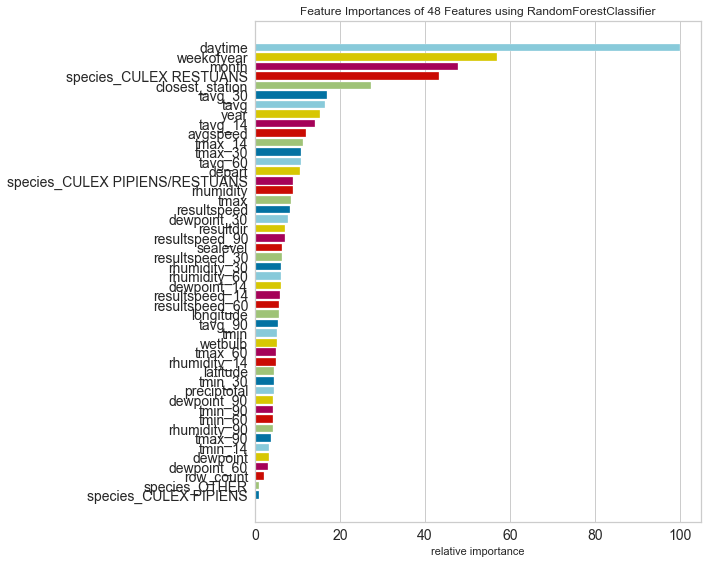

In [106]:
plt.figure(figsize=(10,8))
plt.tick_params(axis='both', labelsize=14)
viz = FeatureImportances(gs_rf.best_estimator_.steps[1][1])
viz.fit(X_train, y_train)
viz.poof();

### ExtraTrees

In [107]:
%%time

# Create a pipeline
# Handle imbalanced class by setting class_weight='balanced' in random forest
pipe_et = Pipeline([('sm', SMOTE(random_state = 42)), 
                    ('et', ExtraTreesClassifier(random_state = 42))])


# hyperparameters for gridsearch
pipe_et_params = {'et__n_estimators': [10, 50, 100],
             'et__max_depth': [2, 4, 10],
             'et__min_samples_leaf': [2, 5, 10],
             'et__class_weight' : ['balanced', 'balanced_subsample'],
            }

# instantiate GridSearchCV
gs_et = GridSearchCV(pipe_rf,
                      param_grid=pipe_rf_params,
                      cv=5,
                      scoring='roc_auc')

# fit model on training data
gs_et.fit(X_train, y_train)

# generate predictions on validation set
et_pred = gs_et.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_et.best_params_)
print('Best CV AUC score: ', gs_et.best_score_)
print('Training AUC score:', gs_et.score(X_train, y_train))
print('Validation AUC score:', gs_et.score(X_val, y_val))

Best parameters:  {'rf__max_depth': 5, 'rf__n_estimators': 200}
Best CV ROC AUC score:  0.8232546305521804
Training ROC AUC score: 0.8720083047906941
Validation ROC AUC score: 0.8199014836001137
CPU times: user 1min 38s, sys: 728 ms, total: 1min 39s
Wall time: 1min 39s


In [108]:
metrics_for_me(y_val, et_pred)

,Metrics
Accuracy,0.739
Misclassification Rate,0.261
Sensitivity(Recall),0.769
Specificity,0.737
Precision,0.140
True Positive,140.000
False Positive,863.000
False Negative,42.000
True Negative,"2,422.000"
ROC Score,0.753


/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


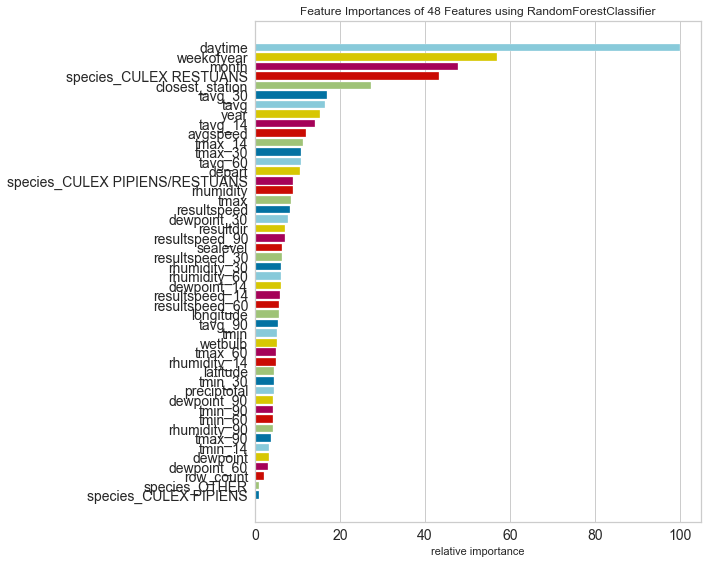

In [109]:
plt.figure(figsize=(10,8))
plt.tick_params(axis='both', labelsize=14)
viz = FeatureImportances(gs_et.best_estimator_.steps[1][1])
viz.fit(X_train, y_train)
viz.poof();

### AdaBoost

In [110]:
# Create a pipeline
pipe_ada = Pipeline([('sm', SMOTE(random_state = 42)), 
                     ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state = 42))])


# hyperparameters for gridsearch
pipe_ada_params = {
    'ada__learning_rate': [0.9,1], #0.1
    'ada__n_estimators': [100], #150
    'ada__base_estimator__max_depth': [1] #2 
}

# instantiate GridSearchCV
gs_ada = GridSearchCV(pipe_ada,
                          param_grid=pipe_ada_params,
                          cv=5,
                          scoring='roc_auc')

# fit model on training data
gs_ada.fit(X_train, y_train)

# generate predictions on validation set
ada_pred = gs_ada.predict(X_val)

# print results
print('Best parameters: ', gs_ada.best_params_)
print('Best CV AUC score: ', gs_ada.best_score_)
print('Training AUC score:', gs_ada.score(X_train, y_train))
print('Validation AUC score:', gs_ada.score(X_val, y_val))

Best parameters:  {'ada__base_estimator__max_depth': 1, 'ada__learning_rate': 1, 'ada__n_estimators': 100}
Best CV ROC AUC score:  0.8145356514634206
Training ROC AUC score: 0.8687936519545105
Validation ROC AUC score: 0.7973121247093851


In [111]:
metrics_for_me(y_val, ada_pred)

,Metrics
Accuracy,0.826
Misclassification Rate,0.174
Sensitivity(Recall),0.571
Specificity,0.840
Precision,0.166
True Positive,104.000
False Positive,524.000
False Negative,78.000
True Negative,"2,761.000"
ROC Score,0.706


/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


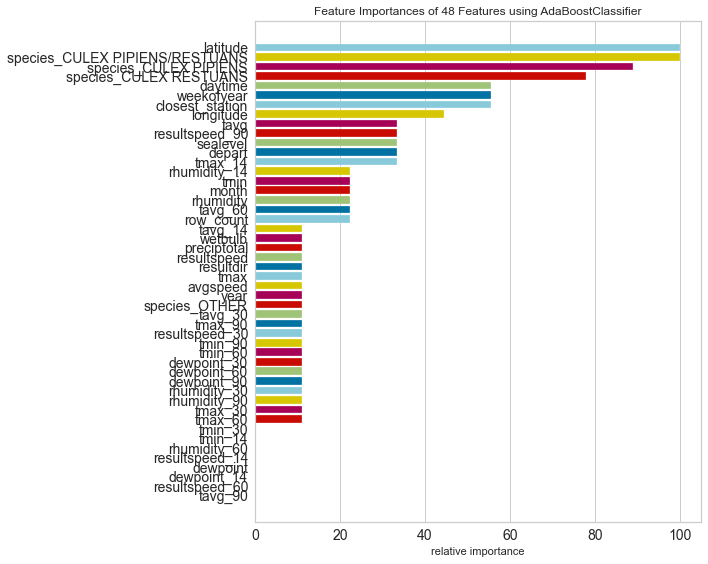

In [182]:
plt.figure(figsize=(10,8))
plt.tick_params(axis='both', labelsize=14)
viz = FeatureImportances(gs_ada.best_estimator_.steps[1][1])
viz.fit(X_train, y_train)
viz.poof();

### Gradient Boosting

In [113]:
# Create a pipeline
pipe_gb = Pipeline([('sm', SMOTE(random_state=42)),
                     ('gb', GradientBoostingClassifier(random_state=42))])

# hyperparameters for gridsearch
pipe_gb_params = {
    'gb__max_depth': [2], #3
    'gb__n_estimators': [100], #150
    'gb__learning_rate': [0.1] 
}

# instantiate GridSearchCV
gs_gb = GridSearchCV(pipe_gb,
                     param_grid= pipe_gb_params,
                     cv=5,
                     scoring='roc_auc')

# fit model on training data
gs_gb.fit(X_train, y_train)

# Generate predictions on validation set
gb_pred = gs_gb.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_gb.best_params_)
print('Best CV AUC score: ', gs_gb.best_score_)
print('Training AUC score:', gs_gb.score(X_train, y_train))
print('Validation AUC score:', gs_gb.score(X_val, y_val))

Best parameters:  {'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__n_estimators': 100}
Best CV ROC AUC score:  0.8242925186795717
Training ROC AUC score: 0.8637939160501049
Validation ROC AUC score: 0.8179119206516466


In [114]:
metrics_for_me(y_val, gb_pred)

,Metrics
Accuracy,0.808
Misclassification Rate,0.192
Sensitivity(Recall),0.648
Specificity,0.816
Precision,0.164
True Positive,118.000
False Positive,603.000
False Negative,64.000
True Negative,"2,682.000"
ROC Score,0.732


/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


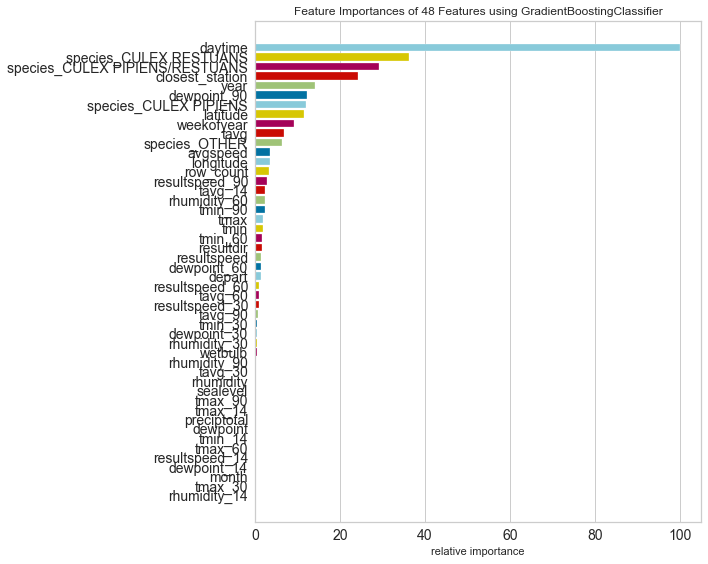

In [115]:
plt.figure(figsize=(10,8))
plt.tick_params(axis='both', labelsize=14)
viz = FeatureImportances(gs_gb.best_estimator_.steps[1][1])
viz.fit(X_train, y_train)
viz.poof();

### XGBoost

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [116]:
# set up pipeline
pipe_xgb = Pipeline([('sm', SMOTE(random_state = 42)), 
                     ('xgb', XGBClassifier(random_state = 42))])

# hyperparameters for gridsearch
pipe_xgb_params = {
    'xgb__eval_metric' : ['auc'],
    'xgb__subsample' : [0.5], # Randomly sample 0.5 of the data to prevent overfitting
    'xgb__colsample_bytree' : [0.5], 
    'xgb__learning_rate' : [0.1], #0.5
    'xgb__max_depth' : [2, 3], #5
#     'xgb__scale_pos_weight': [7963/441], # Ratio of negative class to positive class
    'xgb__n_estimators' : [100], #500
    'xgb__reg_alpha' : [100], # L1 regularization term on weight #0, 1, 50, 75
    'xgb__reg_lambda' : [100], # L2 regularization term on weights #0, 1, 2, 50,75
    'xgb__gamma' : [0.1], # Gamma specifies the minimum loss reduction required to make a split #.2
    'xgb__objective' : ['binary:logistic']
}


# instantiate GridSearchCV
gs_xgb = GridSearchCV(pipe_xgb,
                      param_grid=pipe_xgb_params,
                      cv=5,
                      scoring='roc_auc')

# fit model on training data
gs_xgb.fit(X_train, y_train)

# generate predictions on validation set
xgb_pred = gs_xgb.predict(X_val)

# print results
print('Best parameters: ', gs_xgb.best_params_)
print('Best CV AUC score: ', gs_xgb.best_score_)
print('Training AUC score:', gs_xgb.score(X_train, y_train))
print('Validation AUC score:', gs_xgb.score(X_val, y_val))

Best parameters:  {'xgb__colsample_bytree': 0.5, 'xgb__eval_metric': 'auc', 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__objective': 'binary:logistic', 'xgb__reg_alpha': 100, 'xgb__reg_lambda': 100, 'xgb__subsample': 0.5}
Best CV ROC AUC score:  0.8211856955639174
Training ROC AUC score: 0.8473303998407301
Validation ROC AUC score: 0.8208130530048339


In [117]:
metrics_for_me(y_val, xgb_pred)

,Metrics
Accuracy,0.768
Misclassification Rate,0.232
Sensitivity(Recall),0.731
Specificity,0.770
Precision,0.150
True Positive,133.000
False Positive,755.000
False Negative,49.000
True Negative,"2,530.000"
ROC Score,0.750


/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


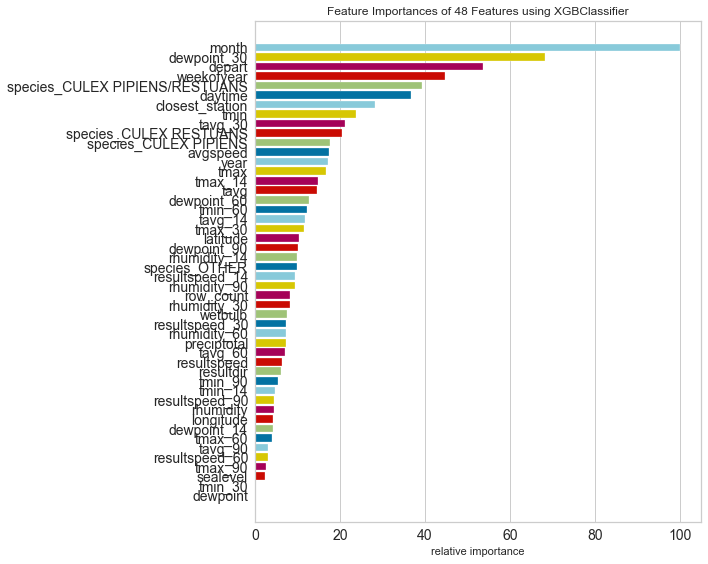

In [118]:
plt.figure(figsize=(10,8))
plt.tick_params(axis='both', labelsize=14)
viz = FeatureImportances(gs_xgb.best_estimator_.steps[1][1])
viz.fit(X_train, y_train)
viz.poof();

## Model evaluation

XGBoost produced the highest AUC score so that will be the final model used.

In [119]:
# looking at the important features
# feature_importance = model.feature_importances_
# feature_df = pd.DataFrame(columns=['feature', 'importance'], 
#              data=list(zip(features, feature_importance))).sort_values('importance',ascending=False).head(19)

## Model with test data

In [169]:
# set up X and y
X_test = test_dum.drop(columns=['date', 'trap', 'yearmonth', 'weekday', 'station', 'id'])

In [179]:
X_test.head()

,latitude,longitude,year,month,weekofyear,closest_station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity,row_count,tavg_14,tavg_30,tavg_60,tavg_90,resultspeed_14,resultspeed_30,resultspeed_60,resultspeed_90,dewpoint_14,dewpoint_30,dewpoint_60,dewpoint_90,rhumidity_14,rhumidity_30,rhumidity_60,rhumidity_90,tmax_14,tmax_30,tmax_60,tmax_90,tmin_14,tmin_30,tmin_60,tmin_90,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHER
0,41.955,-87.801,2008,6,24,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,0,1,0,0
1,41.955,-87.801,2008,6,24,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,0,0,1,0
2,41.955,-87.801,2008,6,24,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,1,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,1,0,0,0
3,41.955,-87.801,2008,6,24,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,5,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,0,0,0,1
4,41.955,-87.801,2008,6,24,1,86,61,73.500,7,56,64,0.000,29.990,8.900,18,10.000,910,54.310,5,73.500,73.500,73.500,73.500,8.900,8.900,8.900,8.900,56.000,56.000,56.000,56.000,54.310,54.310,54.310,54.310,86.000,86.000,86.000,86.000,61.000,61.000,61.000,61.000,0,0,0,1


In [171]:
y_pred = gs_xgb.predict(X_test)

In [176]:
results = pd.DataFrame({'Id': test['id'].values,
              'WnvPresent': y_pred})

In [178]:
results.to_csv('data/submission1.csv', index=False)

# kaggle public score: 0.62880..........

## Outside research on WNV

## Conclusion